In [1]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [2]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-14.csv


In [3]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1256 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3159570057326.4395,USD,425.22,USD,416.72,USD,5.070,USD,1.221392,0.390267,7318857082.52,34157293,89850985.0,169655,21125360.5,21848568.66666667,24640977.63333334,3.043135,1.884023,1.632437,423.676667,38.45812946,Technology Services,1.19540375,1.0122284,1.0291758,0.8906199,6.899062,4.911001,3.525149,2.192062,1.11072451,0.71155325,1.13502082,1.63397957,0.82123352,0.39769984,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,425.50,USD,425.5000,USD,425.5000,USD,425.5000,USD,425.5000,USD,427.1800,USD,427.8200,USD,427.820,USD,427.820,USD,958891.40271493,USD,425.20536,425.232725,424.590,424.263954,425.749704,424.583345,423.416986,427.418903,424.971730,422.524557
1,AAPL,Apple Inc.,NASDAQ,2671445464895.9565,USD,173.00,USD,171.60,USD,1.810,USD,1.057675,0.274645,15427878754.8,72913423,245367044.0,522720,71218790.6999993,62463321.73333383,56556249.75555538,1.847021,1.804847,1.688452,173.119267,26.91769099,Electronic Technology,0.62645935,1.1943091,1.2041771,1.2891104,5.923747,4.866345,3.210545,2.118544,1.13989571,0.66555849,0.80299357,0.93965794,0.87132342,0.59766347,185.53,USD,197.68,USD,199.62,USD,199.62,USD,199.62000,USD,173.12,USD,173.2825,USD,173.2825,USD,173.2825,USD,173.2825,USD,174.0000,USD,174.3078,USD,174.380,USD,180.530,USD,2380652.17391304,USD,172.97400,173.026875,173.046,172.730123,173.192941,173.001035,172.809129,173.941517,173.003915,172.066313
2,AMZN,"Amazon.com, Inc.",NASDAQ,1856744251588.4849,USD,178.75,USD,177.24,USD,1.175,USD,0.665515,0.387981,9234305113.4,43705246,139573821.0,279255,35021075.50000005,46512286.03333333,46590462.86666668,1.736888,2.243530,1.931372,178.248333,61.85977298,Retail Trade,0.77712724,1.1478652,1.3817025,1.1703976,5.328509,4.561935,3.920369,2.659437,1.41830405,0.84031193,0.97753404,1.21298717,0.6316097,0.31128231,180.14,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,178.85,USD,178.8500,USD,178.8500,USD,178.8500,USD,178.8500,USD,179.3884,USD,179.5300,USD,179.530,USD,180.140,USD,376908.19672131,USD,178.65498,178.576850,178.393,178.591915,178.860688,178.298990,177.737292,179.491479,178.765880,178.040281
3,GOOG,Alphabet Inc.,NASDAQ,1787784380232.4517,USD,144.3

In [4]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [5]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.159570e+12,USD,425.22,USD,416.72,USD,5.070,USD,1.221392,0.390267,7318857082.52,34157293,89850985.0,169655,21125360.5,21848568.66666667,24640977.63333334,3.043135,1.884023,1.632437,423.676667,38.45812946,Technology Services,1.19540375,1.0122284,1.0291758,0.8906199,6.899062,4.911001,3.525149,2.192062,1.11072451,0.71155325,1.13502082,1.63397957,0.82123352,0.39769984,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,425.50,USD,425.5000,USD,425.5000,USD,425.5000,USD,425.5000,USD,427.1800,USD,427.8200,USD,427.820,USD,427.820,USD,958891.40271493,USD,425.20536,425.232725,424.590,424.263954,425.749704,424.583345,423.416986,427.418903,424.971730,422.524557,Titans
1,AAPL,Apple Inc.,NASDAQ,2.671445e+12,USD,173.00,USD,171.60,USD,1.810,USD,1.057675,0.274645,15427878754.8,72913423,245367044.0,522720,71218790.6999993,62463321.73333383,56556249.75555538,1.847021,1.804847,1.688452,173.119267,26.91769099,Electronic Technology,0.62645935,1.1943091,1.2041771,1.2891104,5.923747,4.866345,3.210545,2.118544,1.13989571,0.66555849,0.80299357,0.93965794,0.87132342,0.59766347,185.53,USD,197.68,USD,199.62,USD,199.62,USD,199.62000,USD,173.12,USD,173.2825,USD,173.2825,USD,173.2825,USD,173.2825,USD,174.0000,USD,174.3078,USD,174.380,USD,180.530,USD,2380652.17391304,USD,172.97400,173.026875,173.046,172.730123,173.192941,173.001035,172.809129,173.941517,173.003915,172.066313,Titans
2,AMZN,"Amazon.com, Inc.",NASDAQ,1.856744e+12,USD,178.75,USD,177.24,USD,1.175,USD,0.665515,0.387981,9234305113.4,43705246,139573821.0,279255,35021075.50000005,46512286.03333333,46590462.86666668,1.736888,2.243530,1.931372,178.248333,61.85977298,Retail Trade,0.77712724,1.1478652,1.3817025,1.1703976,5.328509,4.561935,3.920369,2.659437,1.41830405,0.84031193,0.97753404,1.21298717,0.6316097,0.31128231,180.14,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,178.85,USD,178.8500,USD,178.8500,USD,178.8500,USD,178.8500,USD,179.3884,USD,179.5300,USD,179.530,USD,180.140,USD,376908.19672131,USD,178.65498,178.576850,178.393,178.591915,178.860688,178.298990,177.737292,179.491479,178.765880,178.040281,Titans
3,GOOG,Alphabet Inc.,NASDAQ,1.787784e+1

In [6]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [7]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1256 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Shrimp,286,22.770701
1,Small caps,271,21.576433
2,Large caps,238,18.949045
3,Micro caps,225,17.914013
4,Midlers,192,15.286624
5,Titans,29,2.308917
6,Undefined,15,1.194268


In [8]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1241 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
1060,CNTX,Context Therapeutics Inc.,NASDAQ,1.772232e+07,USD,1.11,USD,1.18,USD,0.03,USD,2.608696,2.608696,14040109.357,10252,43708.0,1000,55802,39013.9,41815.31111111,10.377358,7.864949,9.124770,1.113333,-,Health Technology,-,1.471003,2.1266289,2.1266289,1.669559,4.012405,3.108575,3.046806,2.02901392,1.32896764,0.25089128,0.17951856,0.23943501,0.35379795,1.2800,USD,1.2800,USD,1.5200,USD,1.6900,USD,10.8700,USD,1.110,USD,1.11,USD,1.11,USD,1.11,USD,1.11,USD,1.160,USD,1.17,USD,1.240,USD,1.255,USD,0,USD,1.12800,1.123762,1.12800,1.131431,1.182146,1.133455,1.084764,1.183101,1.141325,1.099549,Shrimp
1078,MYNZ,Mainz Biomed N.V.,NASDAQ,1.492201e+07,USD,1.02,USD,1.06,USD,0.04,USD,3.883495,2.912621,11458214.976653,96547,388768.0,900,98365.9,107817.1,204849,9.183673,11.222893,9.096115,1.023333,-,Health Technology,-,1.513681,0.1687427,0.1687427,0.344271,0.341646,0.146224,0.180009,0.05909504,0.03977125,0.36195387,0.98298582,0.85268089,0.35767221,1.1400,USD,1.3400,USD,3.4800,USD,6.7000,USD,30.0000,USD,1.020,USD,1.02,USD,1.02,USD,1.02,USD,1.02,USD,1.020,USD,1.07,USD,1.140,USD,1.140,USD,8279.328125,USD,1.00818,1.002612,1.00818,1.002377,1.030621,1.005185,0.979749,1.025929,1.006135,0.986341,Shrimp
216,TER,"Teradyne, Inc.",NASDAQ,1.589742e+10,USD,103.85,USD,105.96,USD,0.51,USD,0.483642,0.483642,152411576.787,1646690,6526092.0,246,1575911.4,1658273.7,1701089.08888889,3.396924,3.519171,2.789898,104.273333,37.98463789,Electronic Technology,0.44471013,1.6021,1.7025745,1.5519282,5.913324,5.681249,6.185791,5.927880,2.39158552,1.17738128,1.02004279,0.99773096,0.78616924,0.4490704,110.9200,USD,113.6000,USD,113.6000,USD,119.2000,USD,168.9100,USD,104.010,USD,104.05,USD,104.05,USD,104.05,USD,104.05,USD,104.950,USD,106.23,USD,108.420,USD,110.920,USD,410881.53846154,USD,103.83300,103.856562,103.67500,103.583846,104.162359,103.683375,103.204391,104.993934,103.901500,102.809066,Large caps
51,SNY,Sanofi,NASDAQ,1.217318e+11,USD,48.09,USD,48.66,USD,0.21,USD,0.435323,0.870647,2502091068.08857,1050386,3390923.0,8636,1363730.1,1879165.53333333,1709293.44444444,1.338072,0.847558,1.270006,48.130000,20.70167886,Health Technology,0.52275634,0.93798274,0.60867316,0.61

In [9]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [10]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [11]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1241
Number of rows removed: 1228
NEW DataFrame length: 13


In [12]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,7,53.846154
1,Titans,2,15.384615
2,Small caps,2,15.384615
3,Midlers,1,7.692308
4,Micro caps,1,7.692308


In [13]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volum

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MA,Mastercard Incorporated,NYSE,4.473028e+11,USD,479.48,USD,477.20,USD,4.48,USD,0.941948,0.334308,8.266160e+08,2757821,8490351.0,505,2115848.69999999,2342694.43333329,2458380.98888888,1.339122,1.167023,1.320006,479.552800,40.52674285,Commercial Services,0.698988,0.9530498,0.89703083,1.0780716,7.856738,8.479930,5.322537,3.938670,2.12563797,1.23320994,1.41951344,1.284297,0.73160919,0.39459863,482.000,USD,482.000,USD,482.0000,USD,482.000,USD,482.0000,USD,480.09,USD,480.09,USD,480.09,USD,480.09,USD,480.09,USD,480.0900,USD,482.00,USD,482.00,USD,482.0000,USD,752305.38922156,USD,479.61300,479.663125,479.16600,478.748462,480.123708,479.187500,478.251292,479.616345,478.690125,477.763905,Titans
1,HD,"Home Depot, Inc. (The)",NYSE,3.734919e+11,USD,375.27,USD,382.47,USD,0.09,USD,0.023747,0.918230,9.927320e+08,3877542,13316594.0,2765,2872587.1,3011931.5,3401496.38888889,2.157616,1.503641,1.466368,375.880000,24.8521533,Retail Trade,0.655114,1.2269979,1.0542859,0.9900517,5.347237,4.321060,5.173134,4.351381,1.9609182,1.10098802,1.04658443,1.326510,0.93595899,0.3894735,385.095,USD,385.095,USD,385.0950,USD,385.095,USD,420.6100,USD,375.58,USD,375.58,USD,375.58,USD,375.58,USD,375.58,USD,375.5800,USD,380.20,USD,382.71,USD,385.0950,USD,329667.4584323,USD,375.23200,375.157500,374.34400,373.666154,375.886581,374.446750,373.006919,375.970347,374.095750,372.221153,Titans
2,TRI,Thomson Reuters Corp,NYSE,7.095884e+10,USD,157.21,USD,158.68,USD,2.28,USD,1.457801,1.457801,1.382877e+08,362129,1403702.0,100,283781.1,334609.1,336118.78888889,2.559107,1.953476,1.650314,157.074267,26.70398124,Technology Services,1.076938,0.5079854,0.62278986,0.4033145,3.056668,3.400757,4.037007,3.580437,1.67197674,0.94306477,1.32352543,1.315613,0.98939829,0.37214641,161.575,USD,161.575,USD,161.5750,USD,161.575,USD,161.5750,USD,157.33,USD,157.33,USD,157.33,USD,157.33,USD,157.33,USD,157.6500,USD,158.99,USD,159.63,USD,159.8600,USD,270257.57459537,USD,157.24200,157.204375,157.00100,157.070154,157.430206,156.981750,156.533294,157.621152,157.144350,156.667548,Large caps
3,ODFL,"Old Dominion Freight Line, Inc.",NASDAQ,4.642666e+10,USD,426.57,USD,438.03,USD,4.21,USD,0.970449,0.97

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [14]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [15]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [16]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [17]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 13/13 [00:00<00:00, 1375.53it/s]


In [18]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-16
END date: 2024-03-14
104 days of historical stock data.

1352 = Length of dataframe
13 = Unique stocks in dataframe
104.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['MA', 'HD', 'TRI', 'ODFL', 'ULTA', 'TSCO', 'SPLK', 'KRTX', 'CNM', 'ASH', 'HIBB', 'BBW', 'GENK']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1342,7.63,8.0433,7.5901,7.89,2024-03-01,GENK,67790,HISTORICAL_PRICES,GENK,,2024-03-01,1709350267000,-0.233936,-0.233936,7.89,7.63,8.0433,7.5901,67790,7.89,7.63,8.0433,7.5901,67790,"Mar 1, 24",-0.25,-0.0317,GENK
1343,7.54,8.0000,7.4700,7.76,2024-03-04,GENK,189542,HISTORICAL_PRICES,GENK,,2024-03-04,1709604036000,-0.242972,-0.242972,7.76,7.54,8.0000,7.4700,189542,7.76,7.54,8.0000,7.4700,189542,"Mar 4, 24",-0.09,-0.0118,GENK
1344,7.28,7.8250,7.0101,7.51,2024-03-05,GENK,106804,HISTORICAL_PRICES,GENK,,2024-03-05,1709692240000,-0.269076,-0.269076,7.51,7.28,7.8250,7.0101,106804,7.51,7.28,7.8250,7.0101,106804,"Mar 5, 24",-0.26,-0.0345,GENK
1345,6.76,7.4850,6.7600,7.25,2024-03-06,GENK,117756,HISTORICAL_PRICES,GENK,,2024-03-06,1709776850000,-0.321285,-0.321285,7.25,6.76,7.4850,6.7600,117756,7.25,6.76,7.4850,6.7600,117756,"Mar 6, 24",-0.52,-0.0714,GENK
1346,5.91,6.9800,5.6100,6.98,2024-03-07,GENK,461109,HISTORICAL_PRICES,GENK,,2024-03-07,1709863230000,-0.406627,-0.406627,6.98,5.91,6.9800,5.6100,461109,6.98,5.91,6.9800,5.6100,461109,"Mar 7, 24",-0.85,-0.1257,GENK
1347,6.07,6.3400,5.7700,5.99,2024-03-08,GENK,176423,HISTORICAL_PRICES,GENK,,2024-03-08,1709951435000,-0.390562,-0.390562,5.99,6.07,6.3400,5.7700,176423,5.99,6.07,6.3400,5.7700,176423,"Mar 8, 24",0.16,0.0271,GENK
1348,6.05,6.1200,5.9601,6.06,2024-03-11,GENK,182610,HISTORICAL_PRICES,GENK,,2024-03-11,1710230497000,-0.392570,-0.392570,6.06,6.05,6.1200,5.9601,182610,6.06,6.05,6.1200,5.9601,182610,"Mar 11, 24",-0.02,-0.0033,GENK
1349,6.28,6.3500,6.1000,6.13,2024-03-12,GENK,120825,HISTORICAL_PRICES,GENK,,2024-03-12,1710297069000,-0.369478,-0.369478,6.13,6.28,6.3500,6.1000,120825,6.13,6.28,6.3500,6.1000,120825,"Mar 12, 24",0.23,0.0380,GENK
1350,6.69,6.7500,6.1900,6.19,2024-03-13,GENK,52684,HISTORICAL_PRICES,GENK,,2024-03-13,1710381674000,-0.328313,-0.328313,6.19,6.69,6.7500,6.1900,52684,6.19,6.69,6.7500,6.1900,52684,"Mar 13, 24",0.41,0.0653,GENK
1351,7.50,7.9600,7.1000,7.10,2024-03-14,GENK,246117,HISTORICAL_PRICES,GENK,,2024-03-14,1710471627000,-0.246988,-0.246988,7.10,7.50,7.9600,7.1000,246117,7.10,7.50,7.9600,7.1000,246117,"Mar 14, 24",0.81,0.1211,GENK


In [19]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [20]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,ASH,2024-03-14,96.13,97.00,94.9150,96.90,417041
1,BBW,2024-03-14,29.02,30.25,26.4400,26.50,1568469
2,CNM,2024-03-14,50.28,50.87,49.8400,50.16,3736276
3,GENK,2024-03-14,7.50,7.96,7.1000,7.10,246117
4,HD,2024-03-14,375.27,380.20,372.1700,378.00,3877542
5,HIBB,2024-03-14,73.03,76.00,71.0000,74.69,619052
6,KRTX,2024-03-14,329.74,329.80,329.6100,329.76,3385979
7,MA,2024-03-14,479.48,482.00,477.1784,481.02,2757821
8,ODFL,2024-03-14,426.57,437.35,420.0100,437.10,973360
9,SPLK,2024-03-14,156.51,156.87,156.1426,156.86,4423778


In [21]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1352


In [22]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [23]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,MA,2023-10-16,401.16,404.43,398.78,400.24,2202218
104,HD,2023-10-16,297.33,298.37,293.58,294.43,2567037
1248,GENK,2023-10-16,9.96,10.49,9.83,9.83,20104
416,ULTA,2023-10-16,387.26,388.21,380.02,382.04,724074
936,ASH,2023-10-16,77.18,77.53,76.07,76.57,381989


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [24]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-16,MA,401.16,404.43,398.78,400.24,2202218
2023-10-16,HD,297.33,298.37,293.58,294.43,2567037
2023-10-16,GENK,9.96,10.49,9.83,9.83,20104
2023-10-16,ULTA,387.26,388.21,380.02,382.04,724074
2023-10-16,ASH,77.18,77.53,76.07,76.57,381989


| TICKER - Unit TESTING | 
|-|

In [29]:
# filter by symbol
ticker = 'HD'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-03-01,HD,384.45,385.0950,379.830,380.36,2750902
2024-03-04,HD,380.37,384.5299,380.110,382.90,2619007
2024-03-05,HD,378.45,380.9800,377.020,380.10,3011731
2024-03-06,HD,377.44,379.8150,375.890,378.53,2496251
2024-03-07,HD,376.55,380.3000,375.575,377.87,2368480
2024-03-08,HD,373.35,376.6200,372.100,375.00,2162906
2024-03-11,HD,371.52,372.9800,368.870,371.56,2833804
2024-03-12,HD,374.54,375.9000,372.405,372.51,2843841
2024-03-13,HD,378.99,382.7100,375.780,376.03,3761407


In [30]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-01,HD,384.45,385.0950,379.830,380.36,2750902
2024-03-04,HD,380.37,384.5299,380.110,382.90,2619007
2024-03-05,HD,378.45,380.9800,377.020,380.10,3011731
2024-03-06,HD,377.44,379.8150,375.890,378.53,2496251
2024-03-07,HD,376.55,380.3000,375.575,377.87,2368480
2024-03-08,HD,373.35,376.6200,372.100,375.00,2162906
2024-03-11,HD,371.52,372.9800,368.870,371.56,2833804
2024-03-12,HD,374.54,375.9000,372.405,372.51,2843841
2024-03-13,HD,378.99,382.7100,375.780,376.03,3761407


| DATA PACKAGE |
|-|
| Trend Lines |


In [31]:
# Step 1: Extract the last 72 closing prices
last_72_df = ticker_df[['Close']].tail(72)
last_72_df['Index'] = np.arange(len(ticker_df) - 72, len(ticker_df))

In [32]:
# Step 2: Perform a linear regression
X = last_72_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
y = last_72_df['Close'].values
model = LinearRegression().fit(X, y)

In [33]:
# Step 3: Calculate the y-values for the line of best fit for the last 72 periods
best_fit_last_72 = model.predict(X)

# Create a series for the best fit line, filled with NaN except for the last 72 values
best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
best_fit_series[-72:] = best_fit_last_72

In [34]:
# Step 4: Pivot Points
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

pivot_point_high_index = last_72_df['Close'].idxmax()
pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# Create a series for the pivot points, similar to the best fit line
pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_low[pivot_point_low_index] = pivot_point_low_value

pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_high[pivot_point_high_index] = pivot_point_high_value

In [35]:
# step 5: chart setup
apds = [
    mpf.make_addplot(best_fit_series, color='orange', width=2),
    mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
    mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
]

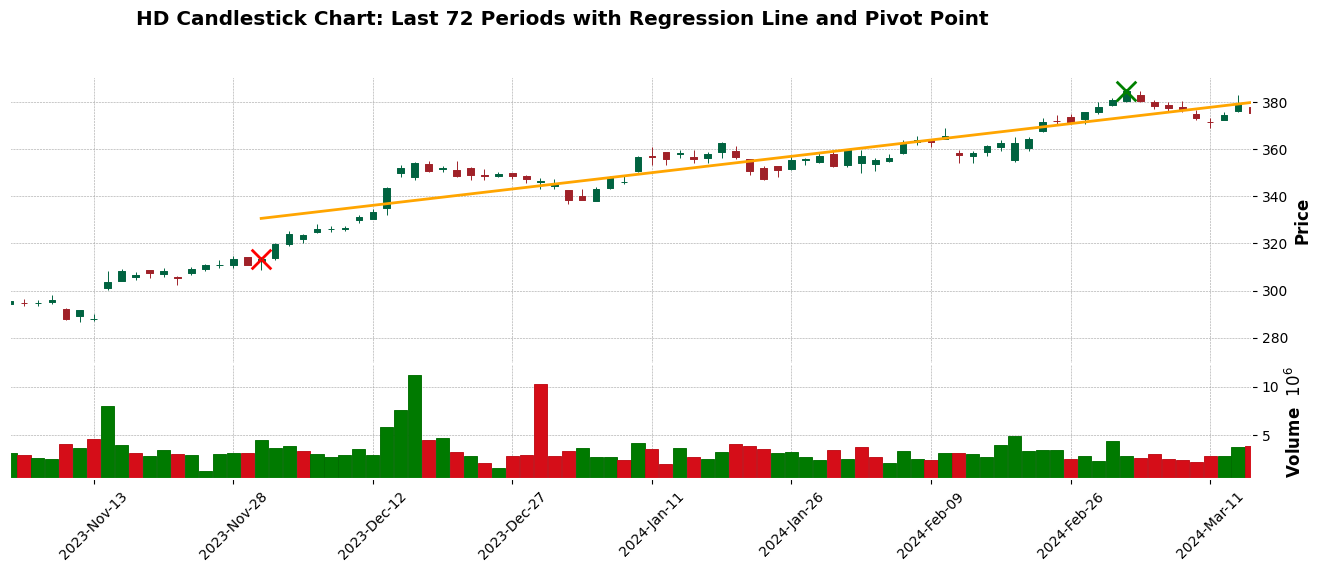

In [36]:
# Step X: chart it
last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
         figratio=(42, 14),
         xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
         addplot=apds)

mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [ ]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [ ]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [ ]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [ ]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [ ]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [ ]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [ ]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [ ]:
# chart_historical_df.head(5)

In [ ]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [ ]:
# # date column check data type
# chart_historical_df.index

In [ ]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [ ]:
# chart_historical_df.index

In [ ]:
# chart_historical_df.head(5)

In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [ ]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [ ]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [ ]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [ ]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [ ]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [ ]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [ ]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [ ]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [ ]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [ ]:
# # check the date column type
# chart_historical_df.index

In [ ]:
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [ ]:
# # get the date column type
# tl_pre_df.index

In [ ]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [ ]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)